In [1]:
#rock paper scissors hand detection training of the data

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import numpy as np
import matplotlib.pyplot as plt # For plotting training history

In [13]:
# --- Configuration ---
IMAGE_SIZE = (128, 128)  # All images will be resized to this
BATCH_SIZE = 32          # Number of images per training step
EPOCHS = 20              # Number of times the model sees the entire dataset (adjust as needed)

# --- IMPORTANT: Set this to the path where your 'rock', 'paper', 'scissors' folders are ---
# Example: If your notebook is in 'my_project/' and data is in 'my_project/data/'
DATA_DIR = 'data'
# If your data is elsewhere, e.g., 'C:/Users/YourUser/Desktop/rps_images'
# DATA_DIR = 'C:/Users/YourUser/Desktop/rps_images'

MODEL_SAVE_PATH = 'rps_hand_detector.h5' # The file name for your trained model

# Create the data directory if it doesn't exist (useful for organizing collected images)
if not os.path.exists(DATA_DIR):
    print(f"Warning: Data directory '{DATA_DIR}' not found. Please create it and place your image folders inside.")
    # You might want to create placeholder folders too
    os.makedirs(os.path.join(DATA_DIR, 'rock'), exist_ok=True)
    os.makedirs(os.path.join(DATA_DIR, 'paper'), exist_ok=True)
    os.makedirs(os.path.join(DATA_DIR, 'scissors'), exist_ok=True)

In [14]:
# --- Data Loading and Preprocessing with Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    shear_range=0.2,         # Randomly apply shearing transformations
    zoom_range=0.2,          # Randomly zoom into images
    horizontal_flip=True,    # Randomly flip images horizontally
    validation_split=0.2     # Use 20% of data for validation
)

# Generator for training data
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    subset='training'
)

# Generator for validation data
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Get class labels (e.g., {'paper': 0, 'rock': 1, 'scissors': 2})
# This dictionary maps class names to their integer indices.
# It's crucial for mapping predictions back to human-readable labels.
class_labels = train_generator.class_indices
# Invert the dictionary to map indices back to labels for display
# For example: {0: 'paper', 1: 'rock', 2: 'scissors'}
CLASS_LABELS_MAP = {v: k for k, v in class_labels.items()}
print("Raw Class Indices:", class_labels)
print("Mapped Class Labels (for detection script):", CLASS_LABELS_MAP)

Found 818 images belonging to 3 classes.
Found 202 images belonging to 3 classes.
Raw Class Indices: {'paper': 0, 'rock': 1, 'scissors': 2}
Mapped Class Labels (for detection script): {0: 'paper', 1: 'rock', 2: 'scissors'}


In [15]:
# --- Model Definition (Simple CNN Architecture) ---
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the 3D output to 1D for the fully connected layers
    Flatten(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout layer to prevent overfitting by randomly setting 50% of input units to 0

    # Output Layer: Number of neurons equals the number of classes, 'softmax' for multi-class probability distribution
    Dense(len(class_labels), activation='softmax')
])

# Print model summary to see its architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# --- Model Compilation ---
# 'adam' optimizer is a good general-purpose optimizer
# 'categorical_crossentropy' is used for multi-class classification where labels are one-hot encoded
# 'accuracy' is the metric to monitor during training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# --- Model Training ---
print("Starting model training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1 # Display training progress
)
print("Model training finished.")

Starting model training...
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3435 - loss: 1.1573 - val_accuracy: 0.3564 - val_loss: 1.1015
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3354 - loss: 1.1033 - val_accuracy: 0.3267 - val_loss: 1.0940
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4107 - loss: 1.0835 - val_accuracy: 0.3416 - val_loss: 1.0839
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5533 - loss: 1.0099 - val_accuracy: 0.4356 - val_loss: 1.0373
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5847 - loss: 0.8967 - val_accuracy: 0.4010 - val_loss: 1.0634
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5987 - loss: 0.8884 - val_accuracy: 0.4653 - val_loss: 1.1594
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6356 - loss: 0.8227 - val_accuracy: 0.5198 - val_loss: 1.0856
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7027 - loss: 0.7214 - val_a

In [18]:
# --- Model Saving ---
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to rps_hand_detector.h5


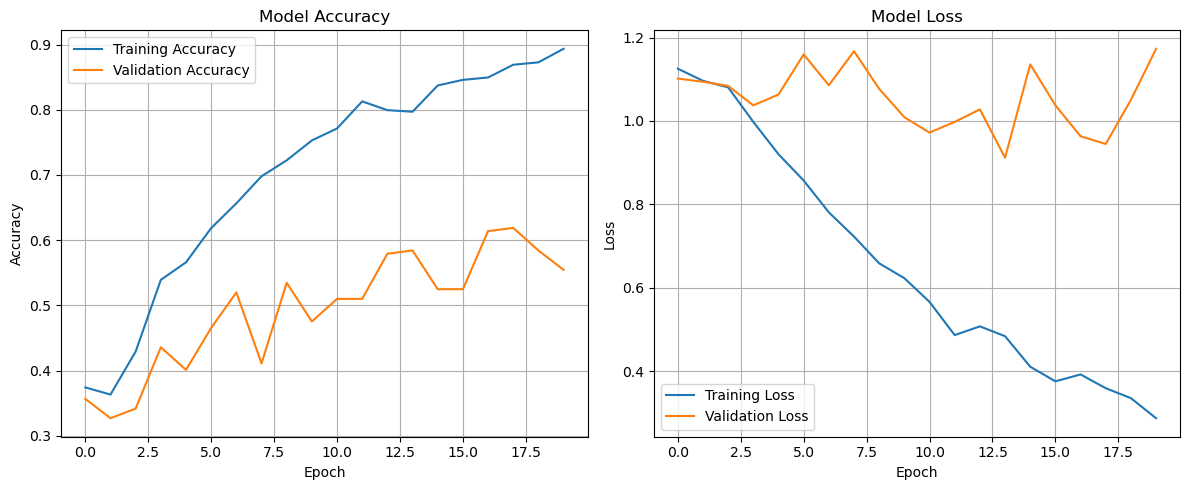

In [19]:
# --- Optional: Plot Training History to visualize performance ---
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()